In [6]:
import os
import random
import torch
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt

from csng.utils import crop, Normalize

lt.monkey_patch()

DATA_PATH = os.path.join(os.environ["DATA_PATH"], "brainreader", "data")
print(f"{DATA_PATH=}")

DATA_PATH='/media/jan/ext_ssd/csng_data/brainreader/data'


In [7]:
config = {
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
        "mouse_v1": None,
        "syn_dataset_config": None,
        "data_augmentation": None,
        "brainreader_mouse": None,
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
    "crop_win": (22, 36),
    "save_run": False,
    "wandb": None,
}

print(f"... Running on {config['device']} ...")
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

... Running on cuda ...


## Data

In [ ]:
### extract data from dataframes to per-sample pickle files
if input("Do you really want to do it again?") not in ["yes", "y"]:
    raise ValueError("Aborted")
sample_idx = 0
for sess_id in range(1, 23):
    for data_part in ["train", "test", "val"]:
        print(f"Processing session {sess_id} {data_part}")
        target_dir = os.path.join(DATA_PATH, str(sess_id), data_part)
        os.makedirs(target_dir, exist_ok=True)

        ### load data
        with open(os.path.join(DATA_PATH, f"{sess_id}_{data_part}_images"), "rb") as f:
            stim = pickle.load(f)
        with open(os.path.join(DATA_PATH, f"{sess_id}_{data_part}_resp"), "rb") as f:
            resp = pickle.load(f)
        assert set(stim.index.get_level_values("image_id").unique()) == set(resp.index.get_level_values("image_id").unique())
        df = pd.merge(stim, resp, on="image_id")
        assert df.shape[0] == stim.shape[0] == resp.shape[0]

        ### save sampels to pickle files separately
        for img_id, row in df.iterrows():
            sample = {
                "image_id": img_id,
                "stim": row["image"],
                "resp": row["response"],
                "blank_resp": row["blank_response"],
            }
            with open(os.path.join(target_dir, f"{img_id}_{sample_idx}.pickle"), "wb") as f:
                pickle.dump(sample, f)
            sample_idx += 1

In [9]:
### prep data config
config["data"]["brainreader_mouse"] = {
    "device": config["device"],
    "mixing_strategy": config["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": DATA_PATH,
    "batch_size": 16,
    "sessions": list(range(1, 23)),
    "normalize_stim": True,
    "normalize_resp": False,
    "div_resp_by_std": True,
    "clamp_neg_resp": False,
    "additional_keys": None,
}

In [10]:
from collections import OrderedDict, namedtuple
from torch.utils.data import DataLoader, Dataset
import torchvision
from collections import defaultdict
from pathlib import Path
from csng.utils import crop, Normalize


class NumpyToTensor:
    def __init__(self, device="cpu", unsqueeze_dims=None):
        self.unsqueeze_dims = unsqueeze_dims
        self.device = device

    def __call__(self, x, *args, **kwargs):
        if self.unsqueeze_dims is not None:
            x = np.expand_dims(x, self.unsqueeze_dims)
        return torch.from_numpy(x).float().to(self.device)

class MixedBatchLoaderV2:
    def __init__(
        self,
        dataloaders,
        neuron_coords=None,
        mixing_strategy="sequential",
        max_batches=None,
        data_keys=None,
        return_data_key=True,
        return_pupil_center=False,
        return_neuron_coords=False,
        device="cpu",
    ):
        assert mixing_strategy in ["sequential", "parallel_min", "parallel_max"], \
            f"mixing_strategy must be one of ['sequential', 'parallel_min', 'parallel_max'], but got {mixing_strategy}"

        self.dataloaders = dataloaders
        self.dataloader_iters = {dl_idx: {"dl": iter(dataloader)} for dl_idx, dataloader in enumerate(dataloaders)}
        self.data_keys = data_keys
        assert len(data_keys) == len(dataloaders), \
            f"len(data_keys) must be equal to len(dataloaders), but got {len(data_keys)} and {len(dataloaders)}"
        for dl_idx, data_key in zip(self.dataloader_iters.keys(), data_keys):
            self.dataloader_iters[dl_idx]["data_key"] = str(data_key)
        self.dataloaders_left = list(self.dataloader_iters.keys())
        self.n_dataloaders = len(self.dataloader_iters)
        self.mixing_strategy = mixing_strategy
        self.max_batches = max_batches
        
        self.neuron_coords = neuron_coords
        self.return_data_key = return_data_key
        self.return_pupil_center = return_pupil_center
        self.return_neuron_coords = return_neuron_coords
        
        self.device = device
        self.batch_idx = 0
        
        if self.mixing_strategy == "sequential":
            self.n_batches = sum([len(dataloader) for dataloader in dataloaders]) if len(dataloaders) > 0 else 0
        elif self.mixing_strategy == "parallel_max":
            self.n_batches = max([len(dataloader) for dataloader in dataloaders]) if len(dataloaders) > 0 else 0
        elif self.mixing_strategy == "parallel_min":
            self.n_batches = min([len(dataloader) for dataloader in dataloaders]) if len(dataloaders) > 0 else 0
        if self.max_batches is not None:
            self.n_batches = min(self.n_batches, self.max_batches)

        self.datasets = dict()
        for dl, data_key in zip(dataloaders, data_keys):
            self.datasets[str(data_key)] = dl.dataset

    def add_dataloader(self, dataloader, neuron_coords=None, data_key=None):
        self.dataloaders.append(dataloader)
        dl_idx = len(self.dataloaders)
        self.dataloader_iters[dl_idx] = {"dl": iter(dataloader)}
        if data_key is not None:
            self.dataloader_iters[dl_idx]["data_key"] = data_key
            if type(self.data_keys) == list:
                self.data_keys.append(data_key)
        self.dataloaders_left.append(dl_idx)
        self.n_dataloaders += 1
        if self.mixing_strategy == "sequential":
            self.n_batches += len(dataloader)
        elif self.mixing_strategy == "parallel_max":
            self.n_batches = max(self.n_batches, len(dataloader))
        elif self.mixing_strategy == "parallel_min":
            self.n_batches = min(self.n_batches, len(dataloader)) \
                if self.n_batches > 0 else len(dataloader)
        if hasattr(dataloader, "dataset"):
            self.datasets.append(dataloader.dataset)
        else:
            self.datasets.append(dataloader)

        if neuron_coords is not None:
            for _data_key, coords in neuron_coords.items():
                if _data_key in self.neuron_coords.keys() \
                    and not torch.equal(self.neuron_coords[_data_key], coords.to(self.device)):
                    print(f"[WARNING]: neuron_coords for data_key {_data_key} already exists and are not the same. Overwriting.")
                self.neuron_coords[_data_key] = coords.to(self.device)

    def _get_sequential(self):
        to_return = []
        while True:
            dl_idx = self.dataloaders_left[self.batch_idx % self.n_dataloaders]
            try:
                datapoint = next(self.dataloader_iters[dl_idx]["dl"])
                to_return.append(dict(data_key=None, stim=None, resp=None, neuron_coords=None, pupil_center=None))
                to_return[-1]["stim"] = datapoint.images.to(self.device)
                to_return[-1]["resp"] = datapoint.responses.to(self.device)
                if self.return_data_key:
                    to_return[-1]["data_key"] = self.dataloader_iters[dl_idx]["data_key"]
                if self.return_neuron_coords:
                    _neuron_coords = self.neuron_coords[self.dataloader_iters[dl_idx]["data_key"]]
                    to_return[-1]["neuron_coords"] = _neuron_coords.to(self.device)
                if self.return_pupil_center:
                    to_return[-1]["pupil_center"] = datapoint.pupil_center.to(self.device)
                break
            except StopIteration:
                ### no more data in this dataloader
                self.dataloaders_left = [_dl_idx for _dl_idx in self.dataloaders_left if _dl_idx != dl_idx]
                del self.dataloader_iters[dl_idx]
                self.n_dataloaders -= 1
                if self.n_dataloaders == 0:  # no more data
                    break
                else:
                    continue

        return to_return
    
    def _get_parallel(self):
        empty_dataloader_idxs = set()
        to_return = []
        for dl_idx, dataloader_iter in self.dataloader_iters.items():
            try:
                datapoint = next(dataloader_iter["dl"])
                to_return.append(dict(data_key=None, stim=None, resp=None, neuron_coords=None, pupil_center=None))
                to_return[-1]["stim"] = datapoint.images.to(self.device)
                to_return[-1]["resp"] = datapoint.responses.to(self.device)
                if self.return_data_key:
                    to_return[-1]["data_key"] = dataloader_iter["data_key"]
                if self.return_neuron_coords:
                    to_return[-1]["neuron_coords"] = self.neuron_coords[dataloader_iter["data_key"]].to(self.device)
                if self.return_pupil_center and "pupil_center" in datapoint._fields:
                    to_return[-1]["pupil_center"] = datapoint.pupil_center.to(self.device)
            except StopIteration:
                ### no more data in this dataloader
                if self.mixing_strategy == "parallel_min":
                    ### end the whole loop
                    empty_dataloader_idxs = set(self.dataloader_iters.keys())
                elif self.mixing_strategy == "parallel_max":
                    ### continue with the remaining ones
                    empty_dataloader_idxs.add(dl_idx)
                else:
                    raise NotImplementedError

        ### remove empty dataloaders
        if len(empty_dataloader_idxs) > 0:
            for dl_idx_to_remove in empty_dataloader_idxs:
                del self.dataloader_iters[dl_idx_to_remove]
            self.n_dataloaders = len(self.dataloader_iters)

        return to_return

    def __len__(self):
        return self.n_batches

    def __iter__(self):
        return self

    def __next__(self):
        self.batch_idx += 1
        if self.mixing_strategy == "sequential":
            out = self._get_sequential()
        elif self.mixing_strategy in ("parallel_min", "parallel_max"):
            out = self._get_parallel()
        else:
            raise NotImplementedError

        if len(out) == 0 or (self.max_batches is not None and self.batch_idx > self.max_batches):
            raise StopIteration

        return out

class PerSampleStoredDataset(Dataset):
    def __init__(
        self,
        dataset_dir,
        stim_transform=None,
        resp_transform=None,
        additional_keys=None,
        clamp_neg_resp=False,
        avg_resp=True,
        device="cpu",
    ):
        self.dataset_dir = dataset_dir
        self.file_names = np.array([
            f_name for f_name in os.listdir(self.dataset_dir)
            if f_name.endswith(".pkl") or f_name.endswith(".pickle")
        ])
        self.parent_dir = Path(self.dataset_dir).parent.absolute()
        self.stim_transform = stim_transform if stim_transform is not None else NumpyToTensor(device=device)
        self.resp_transform = resp_transform if resp_transform is not None else NumpyToTensor(device=device)
        self.additional_keys = additional_keys
        self.clamp_neg_resp = clamp_neg_resp
        self.avg_resp = avg_resp

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        f_name = self.file_names[idx]
        with open(os.path.join(self.dataset_dir, f_name), "rb") as f:
            data = pickle.load(f)
            to_return_keys = ["images", "responses"]
            to_return_vals = [data["stim"], data["resp"]]
            
            ### average responses
            if self.avg_resp:
                to_return_vals[1] = to_return_vals[1].mean(axis=0)

            ### transforms
            if self.stim_transform is not None:
                to_return_vals[0] = self.stim_transform(to_return_vals[0])
            if self.resp_transform is not None:
                to_return_vals[1] = self.resp_transform(to_return_vals[1])
            if self.clamp_neg_resp:
                to_return_vals[1].clamp_min_(0)

            ### additional keys
            if self.additional_keys is not None:
                for key in self.additional_keys:
                    to_return_keys.append(key)
                    to_return_vals.append(data[key])

            return namedtuple("Datapoint", to_return_keys)(*to_return_vals)

def get_brainreader_data(config):
    dls = defaultdict(dict)
    for sess_id in config["sessions"]:
        ### prepare stim transforms
        stim_transform = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize((36, 64)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(lambda x: x.to(config["device"])),
        ])
        if config["normalize_stim"]:
            stim_mean = np.load(os.path.join(DATA_PATH, str(sess_id), "stats", "stimuli_mean.npy")).item()
            stim_std = np.load(os.path.join(DATA_PATH, str(sess_id), "stats", "stimuli_std.npy")).item()
            stim_transform.transforms.append(
                torchvision.transforms.Normalize(mean=stim_mean, std=stim_std)
            )

        ### prepare resp transforms
        resp_transform = torchvision.transforms.Compose([
            NumpyToTensor(device=config["device"]),
        ])
        if config["normalize_resp"]:
            resp_mean = torch.from_numpy(np.load(os.path.join(DATA_PATH, str(sess_id), "stats", "responses_mean.npy"))).to(config["device"])
            resp_std = torch.from_numpy(np.load(os.path.join(DATA_PATH, str(sess_id), "stats", "responses_std.npy"))).to(config["device"])
            resp_transform.transforms.append(
                Normalize(mean=resp_mean, std=resp_std)
            )
        elif config["div_resp_by_std"]:
            resp_std = torch.from_numpy(np.load(os.path.join(DATA_PATH, str(sess_id), "stats", "responses_std.npy"))).to(config["device"])
            resp_transform.transforms.append(
                Normalize(mean=0, std=resp_std)
            )

        ### setup dataloaders
        for data_part in ["train", "test", "val"]:
            dset = PerSampleStoredDataset(
                dataset_dir=os.path.join(config["data_dir"], str(sess_id), data_part),
                stim_transform=stim_transform,
                resp_transform=resp_transform,
                clamp_neg_resp=config["clamp_neg_resp"],
                additional_keys=config["additional_keys"],
                avg_resp=True,
            )
            dls[data_part][str(sess_id)] = DataLoader(
                dset,
                batch_size=config["batch_size"],
                shuffle=True if data_part == "train" else False,
            )
    
    dls_out = {
        "brainreader_mouse": {
            data_part: MixedBatchLoaderV2(
                dataloaders=[dls[data_part][str(sess_id)] for sess_id in config["sessions"]],
                neuron_coords=None,
                mixing_strategy=config["mixing_strategy"],
                max_batches=config["max_batches"],
                data_keys=list(dls[data_part].keys()),
                return_data_key=True,
                device=config["device"],
            ) for data_part in ["train", "test", "val"]
        }
    }

    return dls_out

In [11]:
dls = get_brainreader_data(config["data"]["brainreader_mouse"])

Training dataset:	 99264 samples
Validation dataset:	 11264 samples
Test dataset:		 1232 samples

stimuli:
  torch.Size([16, 1, 36, 64])
  min=-2.330  max=3.038
  mean=0.201  std=1.297
responses:
  torch.Size([16, 9395])
  min=0.000  max=21.506
  mean=0.303  std=0.487


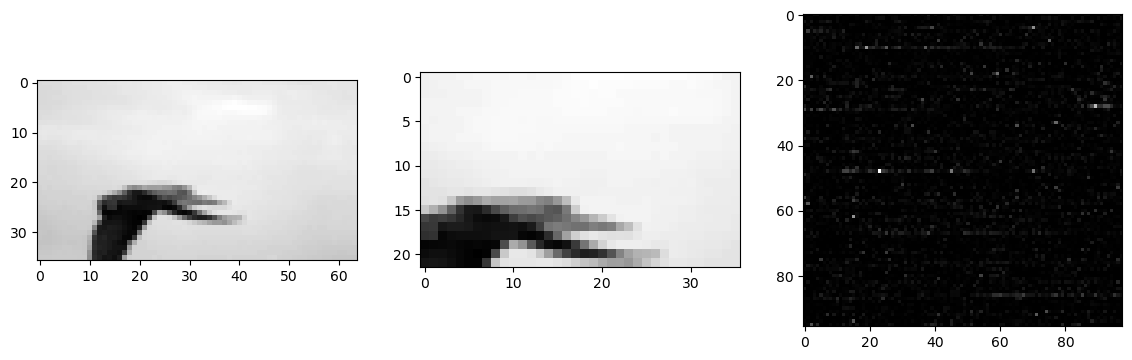

In [ ]:
### show data
sample_data_key = dls["brainreader_mouse"]["test"].data_keys[0]
datapoint = next(iter(dls["brainreader_mouse"]["test"].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
print(
    f"Training dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['brainreader_mouse']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['brainreader_mouse']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * dl.batch_size for dl in dls['brainreader_mouse']['test'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
)

### plot sample data
sample_idx = 0

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].cpu().squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(133)
to_show = resp[sample_idx].cpu()
### pad with zeros
if to_show.shape[-1] % (w := np.sqrt(resp[sample_idx].cpu().shape[0]).astype(int)) != 0:
    to_show = torch.cat([to_show, torch.zeros(w - to_show.shape[-1] % w)], dim=-1)
ax.imshow(to_show.view(w, -1).squeeze(0).unsqueeze(-1), cmap="gray")

In [ ]:
### show data
stim, resp = next(iter(v1_dataloaders["val"]))
print(
    f"{stim.shape=}, {resp.shape=}"
    f"\n{stim.min()=}, {stim.max()=}"
    f"\n{resp.min()=}, {resp.max()=}"
    f"\n{stim.mean()=}, {stim.std()=}"
    f"\n{resp.mean()=}, {resp.std()=}"
)

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[0].squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop_stim(stim[0]).squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(133)
ax.imshow(resp[0].view(125, 375).squeeze(0).unsqueeze(-1), cmap="gray")

plt.show()

In [ ]:
stims, resps = [], []
for b in dls["brainreader_mouse"]["test"]:
    stims.append(b[1]["stim"])
    resps.append(b[1]["resp"])
stims = torch.cat(stims, dim=0)
resps = torch.cat(resps, dim=0)
stims.std((-1,-2)).mean(), stims.mean((-1,-2)).mean(), stims.mean(), resps.std(-1), resps.mean()

## Get statistics of data

In [ ]:
for dset_id in range(1, 23):
    print(f"Session {dset_id}")

    ### collect all training datapoints
    resps, stims = [], []
    for i, datapoint in enumerate(dls["brainreader_mouse"]["train"].datasets[dset_id]):
        resps.append(datapoint.responses.unsqueeze(0))
        stims.append(datapoint.images.unsqueeze(0))
    resps = torch.cat(resps, dim=0)
    print(f"  {resps.shape=}")
    stims = torch.cat(stims, dim=0)
    print(f"  {stims.shape=}")

    ### statistics of responses
    resp_iqr = torch.quantile(resps, 0.75, dim=0) - torch.quantile(resps, 0.25, dim=0)
    resp_mean = resps.mean(dim=0)
    resp_med = torch.median(resps, dim=0).values
    resp_std = resps.std(dim=0)
    print(f"  responses:\n   {resp_iqr=}\n   {resp_mean=}\n   {resp_med=}\n   {resp_std=}")

    ### statistics of stimuli
    stim_mean = stims.mean(dim=(-1, -2)).mean()
    stim_std = stims.std(dim=(-1, -2)).mean()
    print(f"  stimuli:\n   {stim_mean=}\n   {stim_std=}")

    ### create stats directory
    stats_dir = os.path.join(dls["brainreader_mouse"]["train"].datasets[dset_id].parent_dir, "stats")
    print(f"  {stats_dir=}")
    if not os.path.exists(stats_dir):
        os.makedirs(stats_dir)
    else:
        print("[WARNING] stats directory already exists")
        if input("Do you really want to overwrite it?") not in ["yes", "y"]:
            raise ValueError("Aborted")

    ### save stats
    np.save(
        os.path.join(stats_dir, f"responses_iqr.npy"),
        resp_iqr.cpu().numpy(),
    )
    np.save(
        os.path.join(stats_dir, f"responses_mean.npy"),
        resp_mean.cpu().numpy(),
    )
    np.save(
        os.path.join(stats_dir, f"responses_std.npy"),
        resp_std.cpu().numpy(),
    )
    np.save(
        os.path.join(stats_dir, f"responses_median.npy"),
        resp_med.cpu().numpy(),
    )
    np.save(
        os.path.join(stats_dir, f"stimuli_mean.npy"),
        stim_mean.item(),
    )
    np.save(
        os.path.join(stats_dir, f"stimuli_std.npy"),
        stim_std.item(),
    )